In [5]:
import sys
sys.path.append('../src')

import torch
import numpy as np
import gensim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from data.wiki_dataset import WikiDataset
from data.w2v_loader import W2VLoader


from utils.preprocess import custom_transform, remove_footnotes, remove_punctuation
from utils.utils import train_model, evaluate_model
from utils.visualize import visualize_result

In [6]:
WIKI_W2V_PATH  = '../data/wiki.vi.model.bin.gz'
TRAIN_DATA_PATH = "../data/train_wiki_data.csv"
TEST_DATA_PATH = "../data/test_wiki_data.csv"


w2v_loader = W2VLoader(WIKI_W2V_PATH)
w2v_model = w2v_loader.get_model()
VOCAB_SIZE  = w2v_loader.vocab_size
EMBEDDING_DIM = w2v_loader.embedding_dim

TX = 80 # seq_length

np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
def custom_transform(x):
    x = x.lower()
    x = remove_footnotes(x)
    x = remove_punctuation(x)
    x = x.split()
    if len(x) < TX:
        x = x + ['<PAD>'] * (TX - len(x))
    elif len(x) > TX:
        x = x[:TX]
    x = [w2v_model.key_to_index[word] if word in w2v_model.key_to_index else w2v_model.key_to_index['<UNK>'] for word in x]
    x = torch.tensor(x, dtype=torch.long)  # Ensure the tensor is of type long
    return x

transform = transforms.Compose([
    custom_transform,
])

train_dataset = WikiDataset(data_path=TRAIN_DATA_PATH, transform=transform)
train_loader = train_dataset.get_data_loader()

val_dataset = WikiDataset(data_path=TEST_DATA_PATH, transform=transform)
val_loader = val_dataset.get_data_loader()

## RNN based models

### 1. Deep RNN

Epoch 1/40, Train Loss: 1.3159, Train Acc: 0.5938, Val Loss: 1.3702, Val Acc: 0.3300
Epoch 2/40, Train Loss: 1.2096, Train Acc: 0.6195, Val Loss: 1.3767, Val Acc: 0.3175
Epoch 3/40, Train Loss: 1.0942, Train Acc: 0.6162, Val Loss: 1.4462, Val Acc: 0.3075
Epoch 4/40, Train Loss: 1.0098, Train Acc: 0.6294, Val Loss: 1.4970, Val Acc: 0.3450
Epoch 5/40, Train Loss: 0.9889, Train Acc: 0.6294, Val Loss: 1.4945, Val Acc: 0.3650
Epoch 6/40, Train Loss: 0.9771, Train Acc: 0.6398, Val Loss: 1.4614, Val Acc: 0.3750
Epoch 7/40, Train Loss: 0.9736, Train Acc: 0.6447, Val Loss: 1.4683, Val Acc: 0.3675
Epoch 8/40, Train Loss: 0.9693, Train Acc: 0.6475, Val Loss: 1.4560, Val Acc: 0.3850
Epoch 9/40, Train Loss: 0.9595, Train Acc: 0.6491, Val Loss: 1.4552, Val Acc: 0.3825
Epoch 10/40, Train Loss: 0.9577, Train Acc: 0.6524, Val Loss: 1.4502, Val Acc: 0.3875
Epoch 11/40, Train Loss: 0.9606, Train Acc: 0.6541, Val Loss: 1.4404, Val Acc: 0.3850
Epoch 12/40, Train Loss: 0.9526, Train Acc: 0.6491, Val Loss: 1

TypeError: evaluate_model() missing 1 required positional argument: 'device'

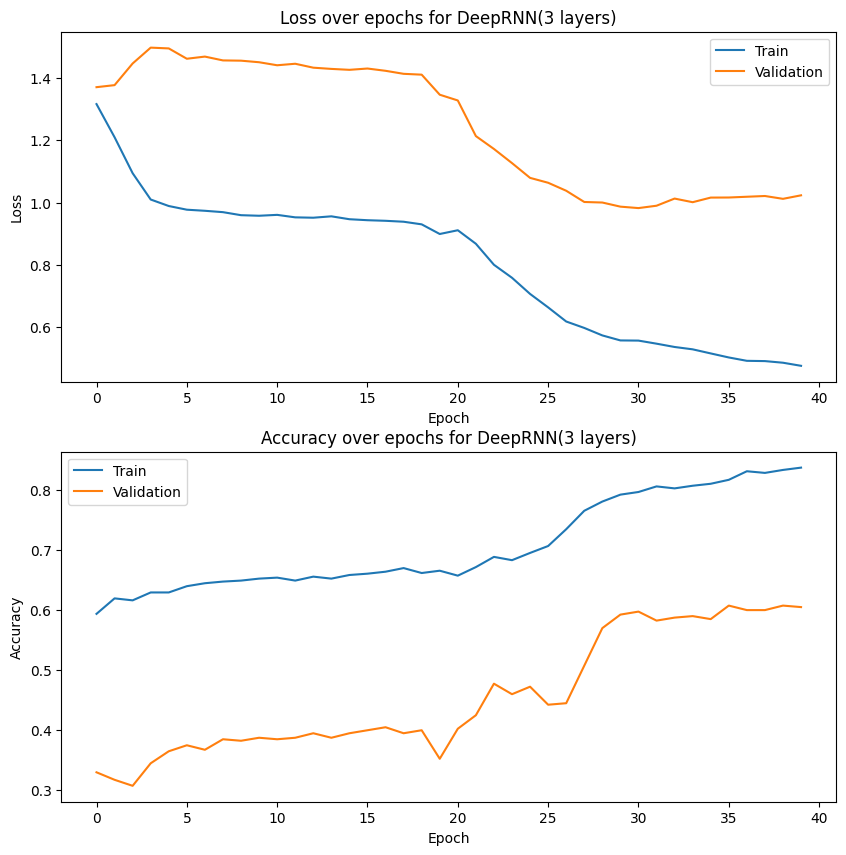

In [8]:
from models.deeprnn import DeepRNN

my_rnn = DeepRNN(input_size=EMBEDDING_DIM, 
             hidden_size=256, 
             num_classes=4, 
             num_layers=3, 
             embed_model=w2v_model,
             dropout_prob=0.3)

# Hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_rnn.parameters(), lr=0.00001)
epochs = 40

rnn_result = train_model(model=my_rnn,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    num_epochs=epochs,
                    return_results=True,
                    device=device)

visualize_result(rnn_result, 'DeepRNN(3 layers)')
print(evaluate_model(my_rnn, val_loader, device='cpu', plot_confusion_matrix=True))

### 2. BiLSTM

In [ ]:
from models.bilstm import BiLSTM

my_bilstm = BiLSTM(input_size=EMBEDDING_DIM, 
                   hidden_size=150, 
                   num_classes=4,
                   embed_model=w2v_model,
                   num_layers=1,
                   dropout_prob=0.5)

# Hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_bilstm.parameters(), lr=0.0003)
epochs = 30

BiLSTM_result = train_model(model=my_bilstm,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    num_epochs=epochs,
                    return_results=True,
                    device=device)

visualize_result(BiLSTM_result, 'BiLSTM')
print(evaluate_model(my_bilstm, val_loader, device='cpu', plot_confusion_matrix=True))

### 3. BiGRU

In [ ]:
from models.bigru import BiGRU

my_bigru = BiGRU(input_size=EMBEDDING_DIM, 
                   hidden_size=256, 
                   num_classes=4,
                   embed_model=w2v_model,
                   num_layers=3,
                   dropout_prob=0.5)

# Hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_bigru.parameters(), lr=0.00005)
epochs = 40

BiGRU_result = train_model(model=my_bigru,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    num_epochs=epochs,
                    return_results=True,
                    device=device)

visualize_result(BiGRU_result, 'BiGRU')
print(evaluate_model(my_bigru, val_loader, device='cpu', plot_confusion_matrix=True))

### 4. BiLSTM + Attention

In [ ]:
from models.bilstm_with_attention import BiLSTMWithAttention

my_BiLSTMwAttention = BiLSTMWithAttention(input_size=EMBEDDING_DIM, 
                   hidden_size=256, 
                   num_classes=4,
                   embed_model=w2v_model,
                   num_layers=2,
                   dropout_prob=0.5)

# Hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_BiLSTMwAttention.parameters(), lr=0.0001, weight_decay=0.01)
epochs = 20

BiLSTMwAttention_result = train_model(model=my_BiLSTMwAttention,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    num_epochs=epochs,
                    return_results=True,
                    device=device)

visualize_result(BiLSTMwAttention_result, 'BiLSTM with Attention')
print(evaluate_model(my_BiLSTMwAttention, val_loader, device='cpu', plot_confusion_matrix=True))

## CNN based models

### 1. TextCNN

In [ ]:
from models.textcnn import TextCNN

# Hyperparameters
epochs = 40
num_filters = 200
kernel_sizes = [3, 4, 5]

my_cnn= TextCNN(
    embedding_dim=EMBEDDING_DIM,
    num_filters=num_filters,
    kernel_sizes=kernel_sizes,
    output_size=4,
    embed_model=w2v_model,
    dropout_prob=0.5
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_cnn.parameters(), lr=0.0005)
cnn_result = train_model(model=my_cnn,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    num_epochs=epochs,
                    return_results=True,
                    device=device)

visualize_result(cnn_result, 'CNN')
print(evaluate_model(my_cnn, val_loader, device='cpu', plot_confusion_matrix=True))

### 2. CharCNN

In [ ]:
# Define preprocess steps for CharCNN
vietnamese_alphabet = 'aáàảãạăắằẳẵặâấầẩẫậbcdđeéèẻẽẹêếềểễệfghiíìỉĩịjklmnoóòỏõọôốồổỗộơớờởỡợpqrstuúùủũụưứừửữựvwxyýỳỷỹỵz0123456789 '

char_to_index = {char: index for index, char in enumerate(vietnamese_alphabet)}
char_to_index['<PAD>'] = len(vietnamese_alphabet) # Embed the padding token
char_to_index['<PAD>'] = int(char_to_index['<PAD>']) # Convert the index to an integer
EMBED_DIM = len(vietnamese_alphabet) + 1 # plus one for the <PAD> token
TX_CHAR = 1014

def custom_char_transform(text):
    text = text.lower()
    x = remove_footnotes(text)
    x = remove_punctuation(x)

    x = [*x]
    x = [char for char in x if char in char_to_index]  # Skip characters not in the dictionary
    if len(x) < TX_CHAR:
        x = x + ['<PAD>'] * (TX_CHAR - len(x))
    else:
        x = x[:TX_CHAR]
    
    x = [char_to_index[char] for char in x]
    # Convert indices to one-hot vectors
    x_one_hot = torch.zeros((EMBED_DIM, TX_CHAR))
    for i, index in enumerate(x):
        x_one_hot[index, i] = 1

    return x_one_hot


char_transform = transforms.Compose([
    custom_char_transform
])

char_train_dataset = WikiDataset(data_path=TRAIN_DATA_PATH, transform=char_transform)
char_train_loader = char_train_dataset.get_data_loader()

char_val_dataset = WikiDataset(data_path=TEST_DATA_PATH, transform=char_transform)
char_val_loader = char_val_dataset.get_data_loader()

In [ ]:
from models.charcnn import CharCNN

# Hyperparameters
epochs = 15

my_charcnn = CharCNN(
    embed_dim=EMBED_DIM,
    num_classes=4,
    seq_length=TX_CHAR,
    dropout_prob=0.5
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_charcnn.parameters(), lr=0.0001)
charcnn_result = train_model(model=my_charcnn,
                    train_loader=char_train_loader,
                    val_loader=char_val_loader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    num_epochs=epochs,
                    return_results=True,
                    device=device)

visualize_result(charcnn_result, 'CharCNN')
print(evaluate_model(my_charcnn, val_loader, device='cpu', plot_confusion_matrix=True))